<a href="https://colab.research.google.com/github/musicjae/NLP/blob/master/gpt2/gpt2_finetuning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Import

In [10]:
!pip install transformers
import pandas as pd
import transformers
from transformers import GPT2Tokenizer,PreTrainedTokenizerFast
import os
import random
from transformers import GPT2LMHeadModel, GPT2Config
import numpy as np
from torch.utils.data import random_split
from transformers import get_linear_schedule_with_warmup
from transformers import AdamW
import datetime
from torch.utils.data import random_split

base = os.getcwd()
print(base)

/content


# Tokenizer

In [5]:
tokenizer = PreTrainedTokenizerFast.from_pretrained("taeminlee/kogpt2")


d = tokenizer.encode("테스트 해봅시다")
print(d)
tokenizer.decode(d)

[5054, 171, 48669, 10723]


'테스트 해봅시다'

# Dataset

In [6]:
df2 = open('/content/drive/MyDrive/Colab_Notebooks/JJY/일기 생성/dataset/0407_diary.txt').read()
df2 = pd.Series(df2.split('\n'))

In [8]:
max_flavour = max([len(tokenizer.encode(card)) for card in df2])
batch_size =2
print(f'가장 긴 문장 길이: {max_flavour}')

가장 긴 문장 길이: 511


In [9]:
import torch
torch.manual_seed(42)
from torch.utils.data import Dataset # this is the pytorch class import

class MTGDataset(Dataset):

  def __init__(self, txt_list, tokenizer, gpt2_type="gpt2", max_length=max_flavour):

    self.tokenizer = tokenizer # the gpt2 tokenizer we instantiated
    self.input_ids = []
    self.attn_masks = []

    for txt in txt_list:

      encodings_dict = tokenizer('<|startoftext|>'+ txt + '<|endoftext|>', 
                                 truncation=True, 
                                 max_length=max_length, 
                                 padding="max_length")

      self.input_ids.append(torch.tensor(encodings_dict['input_ids']))
      self.attn_masks.append(torch.tensor(encodings_dict['attention_mask']))
    
  def __len__(self):
    return len(self.input_ids)

  def __getitem__(self, idx):
    return self.input_ids[idx], self.attn_masks[idx] 

In [11]:
dataset = MTGDataset(df2, tokenizer, max_length=256)

# Split into training and validation sets
train_size = int(0.9 * len(dataset))
val_size = len(dataset) - train_size

train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

f'학습셋: {train_size} 검증셋: {val_size}'

'학습셋: 7396 검증셋: 822'

In [12]:
from torch.utils.data import DataLoader, RandomSampler, SequentialSampler

train_dataloader = DataLoader(
            train_dataset,  
            sampler = RandomSampler(train_dataset), 
            batch_size = batch_size
        )

validation_dataloader = DataLoader(
            val_dataset, 
            sampler = SequentialSampler(val_dataset),
            batch_size = batch_size
        )

# Fine-Tuning GPT2

In [13]:
# Loading the model configuration and setting it to the GPT2 standard settings.
configuration = GPT2Config.from_pretrained('taeminlee/kogpt2', output_hidden_states=False)

# Create the instance of the model and set the token size embedding length
model = GPT2LMHeadModel.from_pretrained("taeminlee/kogpt2", config=configuration)
model.resize_token_embeddings(len(tokenizer))

# Tell pytorch to run this model on the GPU.
device = torch.device("cuda")
model.cuda()

# This step is optional but will enable reproducible runs.
seed_val = 2021

random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)

# 학습 환경 설정

In [15]:
epochs = 1
warmup_steps = 1e2
sample_every = 100

# AdamW is a class from the huggingface library, it is the optimizer we will be using, and we will only be instantiating it with the default parameters. 
optimizer = AdamW(model.parameters(),
                  lr = 5e-4,
                  eps = 1e-8
                )


total_steps = len(train_dataloader) * epochs

scheduler = get_linear_schedule_with_warmup(optimizer, 
                                            num_warmup_steps = warmup_steps, 
                                            num_training_steps = total_steps)

In [16]:
import random
import time
import datetime

def format_time(elapsed):
    return str(datetime.timedelta(seconds=int(round((elapsed)))))

total_t0 = time.time()

training_stats = []

model = model.to(device)

for epoch_i in range(0, epochs):

    print(f'Beginning epoch {epoch_i + 1} of {epochs}')

    t0 = time.time()

    total_train_loss = 0

    model.train()

    for step, batch in enumerate(train_dataloader):

        b_input_ids = batch[0].to(device)
        b_labels = batch[0].to(device)
        b_masks = batch[1].to(device)

        model.zero_grad()        

        outputs = model(  b_input_ids,
                          labels=b_labels, 
                          attention_mask = b_masks,
                          token_type_ids=None
                        )

        loss = outputs[0]  

        batch_loss = loss.item()
        total_train_loss += batch_loss

        # Get sample every 100 batches.
        if step % sample_every == 0 and not step == 0:

            elapsed = format_time(time.time() - t0)
            print(f'Batch {step} of {len(train_dataloader)}. Loss:{batch_loss}. Time:{elapsed}')

            model.eval()

            sample_outputs = model.generate(
                                    bos_token_id=random.randint(1,30000),
                                    do_sample=True,   
                                    top_k=15, 
                                    max_length = 300,
                                    top_p=0.9, 
                                    num_return_sequences=1
                                )
            for i, sample_output in enumerate(sample_outputs):
                  print(f'Example output: {tokenizer.decode(sample_output, skip_special_tokens=True)}')
            
            model.train()

        loss.backward()

        optimizer.step()

        scheduler.step()

    # Calculate the average loss over all of the batches.
    avg_train_loss = total_train_loss / len(train_dataloader)       
    
    # Measure how long this epoch took.
    training_time = format_time(time.time() - t0)

    print(f'Average Training Loss: {avg_train_loss}. Epoch time: {training_time}')

    t0 = time.time()

    model.eval()

    total_eval_loss = 0
    nb_eval_steps = 0

    # Evaluate data for one epoch
    for batch in validation_dataloader:
        
        b_input_ids = batch[0].to(device)
        b_labels = batch[0].to(device)
        b_masks = batch[1].to(device)
        
        with torch.no_grad():        

            outputs  = model(b_input_ids,  
                             attention_mask = b_masks,
                             labels=b_labels)
          
            loss = outputs[0]  
            
        batch_loss = loss.item()
        total_eval_loss += batch_loss        

    avg_val_loss = total_eval_loss / len(validation_dataloader)
    
    validation_time = format_time(time.time() - t0)    

    print(f'Validation loss: {avg_val_loss}. Validation Time: {validation_time}')

    # Record all statistics from this epoch.
    training_stats.append(
        {
            'epoch': epoch_i + 1,
            'Training Loss': avg_train_loss,
            'Valid. Loss': avg_val_loss,
            'Training Time': training_time,
            'Validation Time': validation_time
        }
    )

print(f'Total training took {format_time(time.time()-total_t0)}')

Beginning epoch 1 of 1


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Batch 100 of 3698. Loss:0.26865267753601074. Time:0:00:11
Example output: )]|startoftext|>서울특별시 서초구 서초동 1394-4<|endoftext|>


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Batch 200 of 3698. Loss:0.3647491931915283. Time:0:00:24
Example output: 메리|startoftext|>오늘은 더워지면 더워지는거 같아요.<|endoftext|>


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Batch 300 of 3698. Loss:0.28062376379966736. Time:0:00:38
Example output: 경제민주|startoftext|>다시 돌아왔으면 좋겠는데<|endoftext|>


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Batch 400 of 3698. Loss:0.28998640179634094. Time:0:00:52
Example output: 운행|startoftext|>또다른 메뉴판을 보는 느낌.<|endoftext|>


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Batch 500 of 3698. Loss:0.19560256600379944. Time:0:01:05
Example output: 알루미늄|startoftext|>산책을 즐길 수 있는 곳이 많아요<|endoftext|>


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Batch 600 of 3698. Loss:0.14289988577365875. Time:0:01:19
Example output: 없도록|startoftext|>서울특별시 서초구 매헌로 99<|endoftext|>


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Batch 700 of 3698. Loss:0.6682647466659546. Time:0:01:33
Example output: 건강보험|startoftext|>저희는 양재 시민의 숲을 다녀왔어요.<|endoftext|>


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Batch 800 of 3698. Loss:0.3094818592071533. Time:0:01:46
Example output: 시설에|startoftext|>산책로도 너무 좋다.<|endoftext|>


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Batch 900 of 3698. Loss:0.37563130259513855. Time:0:02:00
Example output: 장기화|startoftext|>그나마 다행스럽게도 그 길을 따라 걸었고<|endoftext|>


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Batch 1000 of 3698. Loss:0.14102250337600708. Time:0:02:14
Example output: 중소|startoftext|>봄날 벚꽃구경,<|endoftext|>


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Batch 1100 of 3698. Loss:0.20891974866390228. Time:0:02:27
Example output: 국회를|startoftext|>양재시민의숲<|endoftext|>


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Batch 1200 of 3698. Loss:0.3008509874343872. Time:0:02:41
Example output: 수용|startoftext|>서울특별시 서초구 양재동 246<|endoftext|>


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Batch 1300 of 3698. Loss:0.48447751998901367. Time:0:02:54
Example output: 시즌에|startoftext|>그중 라떼와 라떼가 가장 예쁘네요.<|endoftext|>


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Batch 1400 of 3698. Loss:0.29059621691703796. Time:0:03:08
Example output: 제품|startoftext|>서울특별시 서초구 매헌로 99<|endoftext|>


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Batch 1500 of 3698. Loss:0.19626960158348083. Time:0:03:22
Example output: 곁|startoftext|>서울특별시 서초구 양재동<|endoftext|>


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Batch 1600 of 3698. Loss:0.2707192301750183. Time:0:03:35
Example output: 전액|startoftext|>서울특별시 서초구 매헌로6길 55 삼륭빌딩 1층<|endoftext|>


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Batch 1700 of 3698. Loss:0.20999905467033386. Time:0:03:49
Example output: 었기|startoftext|>여기서 사진찍는 건 처음이네요ᄏ<|endoftext|>


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Batch 1800 of 3698. Loss:0.3196122646331787. Time:0:04:03
Example output: TomainInfoLayer|startoftext|>아이들도 많이 놀아주는 곳입니다.<|endoftext|>


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Batch 1900 of 3698. Loss:0.35467529296875. Time:0:04:16
Example output: 영역|startoftext|>양재 시민의 숲으로 고고.<|endoftext|>


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Batch 2000 of 3698. Loss:0.2690979540348053. Time:0:04:30
Example output: 0.00|startoftext|>이곳은<|endoftext|>


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Batch 2100 of 3698. Loss:0.16652144491672516. Time:0:04:44
Example output: 연기자|startoftext|>양재시민의숲<|endoftext|>


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Batch 2200 of 3698. Loss:0.15231813490390778. Time:0:04:57
Example output: 길을|startoftext|>양재천에 벚꽃 보러 갈만한 장소들이 많은데<|endoftext|>


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Batch 2300 of 3698. Loss:0.22404813766479492. Time:0:05:11
Example output: !![|startoftext|>이제 다시 한번 방문해봐야겠어요.<|endoftext|>


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Batch 2400 of 3698. Loss:0.1479935199022293. Time:0:05:25
Example output: 주일|startoftext|>이곳의 벚꽃이 너무 이쁘게 피어 있네요.<|endoftext|>


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Batch 2500 of 3698. Loss:0.12620742619037628. Time:0:05:38
Example output: 필요한|startoftext|>양재시민의숲<|endoftext|>


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Batch 2600 of 3698. Loss:0.25445324182510376. Time:0:05:52
Example output: 장안|startoftext|>나뭇잎이 다 떨어졌더라고요!<|endoftext|>


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Batch 2700 of 3698. Loss:0.234502375125885. Time:0:06:06
Example output: ""▶|startoftext|>양재시민의숲 맛집 이자카야에서 맛봤던 것 같다.<|endoftext|>


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Batch 2800 of 3698. Loss:0.4499706029891968. Time:0:06:19
Example output: 카르|startoftext|>그건 꼭꼭꼭꼭꼭꼭꼭꼭꼭꼭꼭꼭 씹어서 맛있어요.<|endoftext|>


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Batch 2900 of 3698. Loss:0.2667350172996521. Time:0:06:33
Example output: 경제성장률|startoftext|>그럴 때쯤, 양재시민의숲에서 <|endoftext|>


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Batch 3000 of 3698. Loss:0.20090734958648682. Time:0:06:47
Example output: 다양한|startoftext|>양재시민의숲<|endoftext|>


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Batch 3100 of 3698. Loss:0.3387731909751892. Time:0:07:00
Example output: 차를|startoftext|>여기에 앉아있던 사람들도<|endoftext|>


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Batch 3200 of 3698. Loss:0.27013078331947327. Time:0:07:14
Example output: 체험|startoftext|>봄이면 벚꽃이 이렇게 활짝 피는데<|endoftext|>


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Batch 3300 of 3698. Loss:0.19190295040607452. Time:0:07:27
Example output: 원칙|startoftext|>한스펌킨 카페가 아니라 <|endoftext|>


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Batch 3400 of 3698. Loss:0.1731448918581009. Time:0:07:41
Example output: 권역|startoftext|>그리고 양재시민의숲은 도심에서 보기 힘든 울창한 숲이랍니다.<|endoftext|>


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Batch 3500 of 3698. Loss:0.10275308042764664. Time:0:07:55
Example output: 일제강점|startoftext|>이 곳도 서울 단풍 명소중 한 곳이라 그런지<|endoftext|>


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Batch 3600 of 3698. Loss:0.28521862626075745. Time:0:08:08
Example output: 1964|startoftext|>여기서 사진을 찍고 싶은 생각이 들었다.<|endoftext|>
Average Training Loss: 0.2708785564952473. Epoch time: 0:08:22
Validation loss: 0.24477903352746708. Validation Time: 0:00:12
Total training took 0:08:34


# 학습 과정 확인

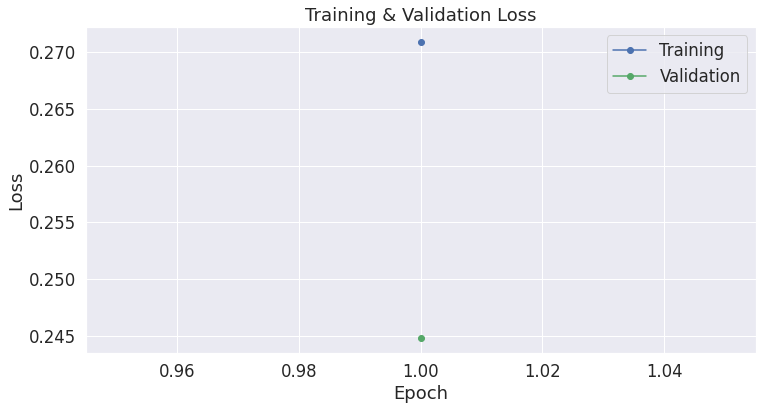

In [17]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

x_series = np.arange(100)
% matplotlib inline

pd.set_option('precision', 2)
df_stats = pd.DataFrame(data=training_stats)
df_stats = df_stats.set_index('epoch')

# Use plot styling from seaborn.
sns.set(style='darkgrid')

# Increase the plot size and font size.
sns.set(font_scale=1.5)
plt.rcParams["figure.figsize"] = (12,6)

# Plot the learning curve.
plt.plot(df_stats['Training Loss'], 'b-o', label="Training")
plt.plot(df_stats['Valid. Loss'], 'g-o', label="Validation")

# Label the plot.
plt.title("Training & Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()


plt.show()

# 추론

In [18]:
model.eval()

prompt = "산책"

generated = torch.tensor(tokenizer.encode(prompt)).unsqueeze(0)
generated = generated.to(device)

sample_outputs = model.generate(
                                generated, 
                                do_sample=True,   
                                top_k=10, 
                                max_length = 200,
                                top_p=0.9, 
                                num_return_sequences=3
                                )

for i, sample_output in enumerate(sample_outputs):
    res = tokenizer.decode(sample_output, skip_special_tokens=True)
    res = res.replace('<eos><|endoftext|>','')
    res = res.replace('<|endoftext|> ','')
    res = res.replace('<|startoftext|>','')
    res = res.replace('<|endoftext|>','')
    res = res.replace('<eos><|endof ','')
    res = res.replace('산책|>','')
    res = res.replace('산책|','')
    res = res.replace('<|endoftext|> ','')
    res = res.replace('startoftext|>','')
    print(res,'\n')

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


양재시민의숲은 양재시민의숲과 연결되어있어서 양재 시민의숲을 산책하는 사람들도 많다. 

양재시민의숲역 맛집으로  

양재시민의숲은 서울둘레길 3코스 중 하나라 

